In [1]:
# import numpy as np
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, TimeDistributed, LSTM, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [2]:
# http://finance.yahoo.com/quote/GOOG/history?ltr=1
Stock = pd.read_csv("StockDaily.csv")
Stock.head()

,Open,High,Low,Volume,Close
0,828.659973,833.450012,828.349976,1247700,831.659973
1,823.020020,828.070007,821.655029,1597800,828.070007
2,819.929993,824.400024,818.979980,1281700,824.159973
3,819.359985,823.000000,818.469971,1304000,818.979980
4,819.000000,823.000000,816.000000,1053600,820.450012


Text(0, 0.5, 'price')

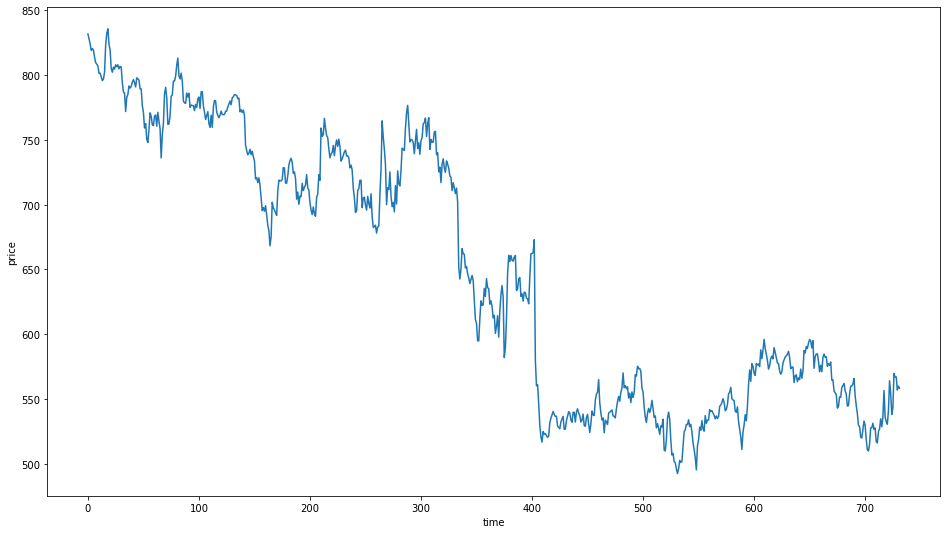

In [3]:
import seaborn

plt.figure(figsize=(16, 9))
seaborn.lineplot(x = Stock.index, y="Close", data=Stock)
plt.xlabel('time')
plt.ylabel('price')

## Data Split (Train, Test 나누기) / 윈도우 (1) 정하기

In [8]:
PrevClose = [0]
PrevClose.extend(list(Stock['Close'][:-1]))
Stock['PrevClose'] = PrevClose

In [9]:
Stock.head()

,Open,High,Low,Volume,Close,PrevClose
0,828.659973,833.450012,828.349976,1247700,831.659973,0.000000
1,823.020020,828.070007,821.655029,1597800,828.070007,831.659973
2,819.929993,824.400024,818.979980,1281700,824.159973,828.070007
3,819.359985,823.000000,818.469971,1304000,818.979980,824.159973
4,819.000000,823.000000,816.000000,1053600,820.450012,818.979980


In [10]:
Stock = Stock[1:]

In [12]:
from sklearn.preprocessing import scale
Stock = pd.DataFrame(scale(Stock), index=Stock.index, columns=Stock.columns)

In [13]:
Stock.head()

,Open,High,Low,Volume,Close,PrevClose
1,1.736381,1.727679,1.785482,-0.313301,1.786828,1.815531
2,1.705750,1.691479,1.758894,-0.629719,1.748115,1.780048
3,1.700099,1.677669,1.753824,-0.607397,1.696828,1.741401
4,1.696531,1.677669,1.729274,-0.858048,1.711383,1.690203
5,1.666792,1.657537,1.724205,-0.713403,1.699402,1.704732


In [14]:
Data_x = Stock[['Open', 'High', 'Low', 'Volume', 'PrevClose']]
Data_y = Stock[['Close']]

Data_x = Data_x[:-1]
Data_y = Data_y[1:]

print(Data_x[:-1].shape)
print(Data_y[1:].shape)

(729, 5)
(729, 1)


In [15]:
# 200개는 test set으로 split
Train_x = Data_x[:-200]
Train_y = Data_y[:-200]

Valid_x = Data_x[-200:]
Valid_y = Data_y[-200:]

In [17]:
print(Train_x.shape)
print(Train_y.shape)
print(Valid_x.shape)
print(Valid_y.shape)

(530, 5)
(530, 1)
(200, 5)
(200, 1)


In [27]:
def make_window_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [28]:
window_size = 20
Train_x_window, Train_y_window = make_window_dataset(Train_x, Train_y, window_size=20)
Valid_x_window, Valid_y_window = make_window_dataset(Valid_x, Valid_y, window_size=20)

<Window로 생성한 time-series data>

In [29]:
Train_x_window[0][0:5]

array([[ 1.73638095,  1.72767896,  1.78548236, -0.31330146,  1.81553058],
       [ 1.70574957,  1.69147888,  1.75889368, -0.62971905,  1.7800477 ],
       [ 1.70009909,  1.67766929,  1.75382445, -0.60739665,  1.7414013 ],
       [ 1.69653056,  1.67766929,  1.72927414, -0.85804822,  1.69020275],
       [ 1.66679162,  1.65753706,  1.72420489, -0.71340304,  1.7047324 ]])

In [30]:
Train_x_window[1][0:5]

array([[ 1.70574957,  1.69147888,  1.75889368, -0.62971905,  1.7800477 ],
       [ 1.70009909,  1.67766929,  1.75382445, -0.60739665,  1.7414013 ],
       [ 1.69653056,  1.67766929,  1.72927414, -0.85804822,  1.69020275],
       [ 1.66679162,  1.65753706,  1.72420489, -0.71340304,  1.7047324 ],
       [ 1.62416591,  1.60122463,  1.66745068, -0.78247237,  1.69277266]])

<데이터 형태 이해>

In [31]:
print(Train_x.shape)
print(Train_y.shape)
print(Train_x_window.shape)
print(Train_y_window.shape)

(530, 5)
(530, 1)
(510, 20, 5)
(510, 1)


In [37]:
# 모델 구성
model = Sequential()

# RNN. 현재 RNN은 return_sequences (모든 x time-step에 대하여 output을 냄)
model.add(LSTM(20, activation='linear', return_sequences = False, input_shape=( window_size, len(Train_x.columns),  )))
model.add(Dense(1, activation='linear'))
model.compile(loss = "mean_squared_error", optimizer=Adam(learning_rate=0.001))

In [33]:
# Call-back 함수
# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='MODEL/{epoch:03d}-{loss:.4f}-{val_loss:.4f}.hdf5',
            monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#minitor -> loss -> val_loss

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=4, verbose=1, min_lr=1e-8)
# factor: Learning rate에 곱할 것.
#0.1 -> 0.08 -> 0.064 ....
#monitor='loss' -> monitor='val_loss'

CALLBACK = [CP, LR]

In [38]:
history = model.fit(Train_x_window, Train_y_window, 
        epochs=20, 
        batch_size=10,
        callbacks=CALLBACK,
        validation_data=(Valid_x_window, Valid_y_window)
)

Epoch 1/20
51/51 [==============================] - 2s 27ms/step - loss: 0.2190 - val_loss: 0.0177

Epoch 00001: val_loss improved from 0.01805 to 0.01770, saving model to MODEL\001-0.1175-0.0177.hdf5
Epoch 2/20
51/51 [==============================] - 1s 22ms/step - loss: 0.0493 - val_loss: 0.0175

Epoch 00002: val_loss improved from 0.01770 to 0.01753, saving model to MODEL\002-0.0381-0.0175.hdf5
Epoch 3/20
51/51 [==============================] - 1s 20ms/step - loss: 0.0413 - val_loss: 0.0214

Epoch 00003: val_loss did not improve from 0.01753
Epoch 4/20
51/51 [==============================] - 1s 20ms/step - loss: 0.0317 - val_loss: 0.0229

Epoch 00004: val_loss did not improve from 0.01753
Epoch 5/20
51/51 [==============================] - 1s 20ms/step - loss: 0.0267 - val_loss: 0.0204

Epoch 00005: val_loss did not improve from 0.01753
Epoch 6/20
51/51 [==============================] - 1s 21ms/step - loss: 0.0245 - val_loss: 0.0219

Epoch 00006: val_loss did not improve from 0.

# 최적의 모델 찾아서 Load

In [183]:
model.load_weights('MODEL/080-24236.5957-494.9185.hdf5')

In [39]:
PredStock = model.predict(Valid_x_window)
PredStock.shape

(180, 1)

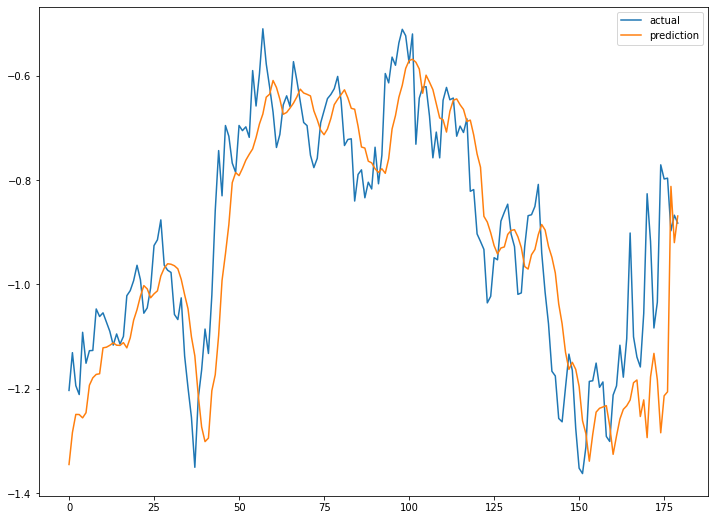

In [40]:
plt.figure(figsize=(12, 9))
plt.plot(Valid_y_window, label = 'actual')
plt.plot(PredStock, label = 'prediction')
plt.legend()
plt.show()